# DANTE 合金材料设计优化

本笔记本演示如何使用DANTE框架进行Co-Mo-Ti-Fe四元合金材料的成分优化，以获取最佳的机械性能（弹性模量和屈服强度的组合）。其中Fe为基体元素，四个元素总和为100%。

## 内容概览

1. **第一部分**：数据加载与预处理
2. **第二部分**：定义DANTE算法组件
3. **第三部分**：构建神经网络代理模型
4. **第四部分**：使用DANTE进行优化
5. **第五部分**：结果可视化与分析

## 第一部分：数据加载与预处理

首先导入必要的库，并加载合金材料数据集。

In [1]:
# 导入必要的库
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 设置可视化样式
plt.style.use('ggplot')
sns.set(style="whitegrid")

# 检查数据文件是否存在
data_path = "data.csv"
if os.path.exists(data_path):
    print(f"数据文件 {data_path} 存在")
else:
    print(f"警告：数据文件 {data_path} 不存在！")
    
    # 如果在上级目录中有数据文件，尝试复制它
    parent_data_path = "../../../data.csv"
    if os.path.exists(parent_data_path):
        print(f"在上级目录中找到数据文件，正在复制到当前目录...")
        import shutil
        shutil.copy(parent_data_path, data_path)
        print("复制完成！")
    else:
        print("在上级目录中也没有找到数据文件，请确保数据文件可用。")

# 如果数据文件存在，加载它
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print(f"成功加载数据集，共 {len(df)} 个样本")
    print("\n数据集前5行：")
    display(df.head())
else:
    print("无法加载数据集，请确保数据文件可用。")
    df = None

数据文件 data.csv 存在
成功加载数据集，共 621 个样本

数据集前5行：


,sid,elastic,yield,phase_ratio_dict,ds
0,Co8.50Mo5.15Ti2.60,1.420000e+11,999045917.8,"{""martensite"": 0.6559944215529168, ""Fe2Mo"": 0....",20250304
1,Co8.50Mo5.25Ti2.20,1.190000e+11,850372168.9,"{""martensite"": 0.6366681307104562, ""Fe2Mo"": 0....",20250304
2,Co8.50Mo5.25Ti0.80,8.903661e+10,641555721.0,"{""martensite"": 0.5781999583214714, ""Fe2Mo"": 0....",20250304
3,Co8.50Mo5.45Ti2.60,1.330000e+11,945353657.3,"{""martensite"": 0.6500110673714325, ""Fe2Mo"": 0....",20250304
4,Co8.50Mo4.90Ti1.60,1.070000e+11,780448554.7,"{""martensite"": 0.6179089154319106, ""Fe2Mo"": 0....",20250304


### 数据预处理

现在我们需要提取合金成分信息和目标属性（弹性模量和屈服强度）。合金系统为Co-Mo-Ti-Fe四元合金，其中Fe为基体元素，根据其他三元素含量计算得出（Fe = 100 - Co - Mo - Ti）。


数据处理摘要：
输入维度: (621, 4) (现在包含4个元素: Co, Mo, Ti, Fe)
输出维度: (621,)
弹性模量平均值: 1.21e+11
屈服强度平均值: 856914898.26

成分范围：
Co: 8.50 to 11.20%
Mo: 4.90 to 5.50%
Ti: 0.80 to 3.00%
Fe: 80.30 to 85.80%

成分总和检查: 100.00 to 100.00 (应为100%)


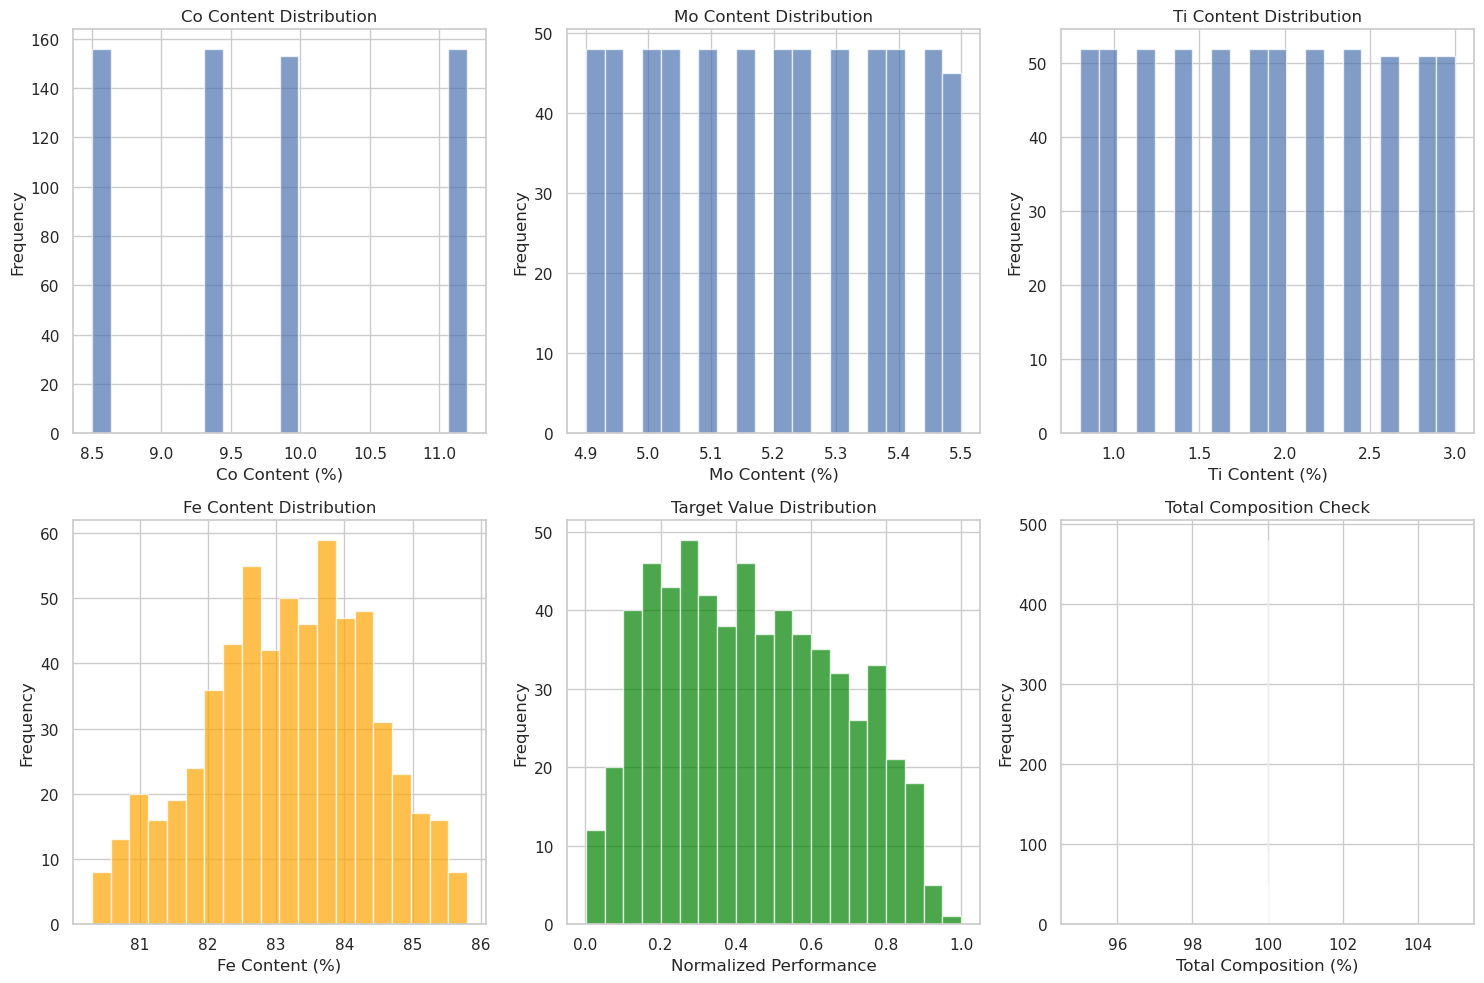

<Figure size 1200x1000 with 0 Axes>

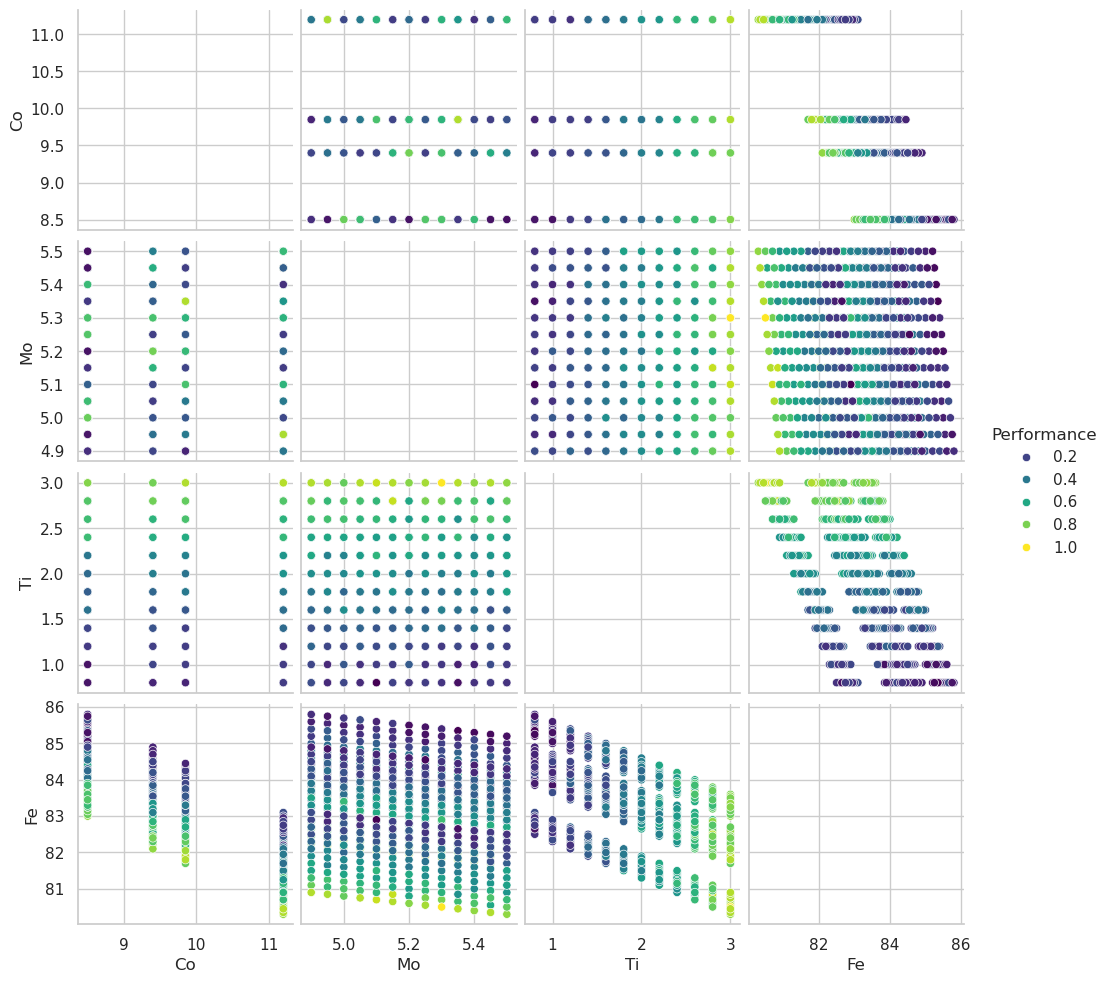

In [2]:
def extract_composition(sid):
    """
    从材料ID中提取元素成分
    
    示例：从 "Co8.50Mo5.15Ti2.60" 提取 [8.50, 5.15, 2.60, 83.75] (Co, Mo, Ti, Fe)
    其中Fe = 100 - Co - Mo - Ti
    """
    elements = ['Co', 'Mo', 'Ti']
    values = []
    
    # 提取每个元素的数值
    for element in elements:
        if element in sid:
            # 找到元素在字符串中的位置
            pos = sid.find(element) + len(element)
            # 找到下一个元素的位置或字符串结尾
            next_pos = len(sid)
            for next_elem in elements:
                if next_elem != element and sid.find(next_elem, pos) != -1:
                    next_pos = min(next_pos, sid.find(next_elem, pos))
            # 提取数值
            value = float(sid[pos:next_pos])
            values.append(value)
        else:
            values.append(0.0)
    
    # 计算铁元素含量（余量）
    co, mo, ti = values
    fe = 100.0 - co - mo - ti
    
    # 返回四元素成分: [Co, Mo, Ti, Fe]
    return [co, mo, ti, fe]


if df is not None:
    # 提取每个数据点的成分值
    composition_values = df['sid'].apply(extract_composition)
    X = np.array(composition_values.tolist())
    
    # 提取目标值（弹性模量和屈服强度）并标准化（归一化到0-1区间）
    elastic_values = df['elastic'].values
    yield_values = df['yield'].values

    elastic_min = np.min(elastic_values)
    elastic_max = np.max(elastic_values)
    yield_min = np.min(yield_values)
    yield_max = np.max(yield_values)

    # 归一化到0-1区间
    elastic_norm = (elastic_values - elastic_min) / (elastic_max - elastic_min)
    yield_norm = (yield_values - yield_min) / (yield_max - yield_min)

    # 计算均值用于后续摘要
    elastic_mean = np.mean(elastic_values)
    yield_mean = np.mean(yield_values)
    
    # 将目标定义为标准化值的平均值
    Y = (elastic_norm + yield_norm) / 2
    
    print("\n数据处理摘要：")
    print(f"输入维度: {X.shape} (现在包含4个元素: Co, Mo, Ti, Fe)")
    print(f"输出维度: {Y.shape}")
    print(f"弹性模量平均值: {elastic_mean:.2e}")
    print(f"屈服强度平均值: {yield_mean:.2f}")
    
    # 显示成分范围
    print("\n成分范围：")
    print(f"Co: {X[:, 0].min():.2f} to {X[:, 0].max():.2f}%")
    print(f"Mo: {X[:, 1].min():.2f} to {X[:, 1].max():.2f}%")
    print(f"Ti: {X[:, 2].min():.2f} to {X[:, 2].max():.2f}%")
    print(f"Fe: {X[:, 3].min():.2f} to {X[:, 3].max():.2f}%")
    
    # 验证成分总和是否为100%
    total_compositions = np.sum(X, axis=1)
    print(f"\n成分总和检查: {total_compositions.min():.2f} to {total_compositions.max():.2f} (应为100%)")
    
    # 绘制数据分布
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.hist(X[:, 0], bins=20, alpha=0.7)
    plt.title('Co Content Distribution')
    plt.xlabel('Co Content (%)')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 3, 2)
    plt.hist(X[:, 1], bins=20, alpha=0.7)
    plt.title('Mo Content Distribution')
    plt.xlabel('Mo Content (%)')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 3, 3)
    plt.hist(X[:, 2], bins=20, alpha=0.7)
    plt.title('Ti Content Distribution')
    plt.xlabel('Ti Content (%)')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 3, 4)
    plt.hist(X[:, 3], bins=20, alpha=0.7, color='orange')
    plt.title('Fe Content Distribution')
    plt.xlabel('Fe Content (%)')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 3, 5)
    plt.hist(Y, bins=20, alpha=0.7, color='green')
    plt.title('Target Value Distribution')
    plt.xlabel('Normalized Performance')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 3, 6)
    plt.hist(total_compositions, bins=20, alpha=0.7, color='red')
    plt.title('Total Composition Check')
    plt.xlabel('Total Composition (%)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # 绘制散点图矩阵（由于是4元素，选择前3个显示）
    plt.figure(figsize=(12, 10))
    df_plot = pd.DataFrame({
        'Co': X[:, 0], 
        'Mo': X[:, 1], 
        'Ti': X[:, 2], 
        'Fe': X[:, 3],
        'Performance': Y
    })
    # 使用前4个列进行散点图矩阵
    sns.pairplot(df_plot[['Co', 'Mo', 'Ti', 'Fe', 'Performance']], 
                 hue='Performance', palette='viridis', diag_kind='kde')
    plt.show()

## 第二部分：定义DANTE算法组件

在这一部分，我们将定义DANTE框架所需的组件，包括目标函数和深度主动学习模块。首先，我们需要确保DANTE模块可以被导入。

In [3]:
# 添加DANTE模块到路径
print(os.path.abspath(os.path.join(os.getcwd(), "../..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

# 尝试导入DANTE模块
try:
    from dante.neural_surrogate import SurrogateModel
    from dante.deep_active_learning import DeepActiveLearning
    from dante.obj_functions import ObjectiveFunction
    from dante.tree_exploration import TreeExploration
    from dante.utils import generate_initial_samples, Tracker
    print("成功导入DANTE模块！")
except ImportError as e:
    print(f"导入DANTE模块失败: {e}")
    print("请确保DANTE已正确安装，或检查路径是否正确。")

/home/test/1/1.2/DANTE


2025-05-26 12:37:04.487994: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 12:37:04.493136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-26 12:37:04.499549: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-26 12:37:04.501620: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 12:37:04.507221: I tensorflow/core/platform/cpu_feature_guar

成功导入DANTE模块！


### 定义合金优化的目标函数

我们需要创建一个特定的目标函数类，用于合金材料的性能优化。

In [4]:
class AlloyObjectiveFunction(ObjectiveFunction):
    """
    合金材料优化的目标函数。
    优化目标是最大化弹性模量和屈服强度的综合性能。
    合金系统: Co-Mo-Ti-Fe (四元素)
    """
    def __init__(self, X_data, Y_data, dims=4, turn=0.01):
        self.name = "alloy_optimization_quaternary"
        
        # 存储训练数据
        self.X_data = X_data
        self.Y_data = Y_data
        
        # 计算数据统计信息，用于缩放
        self.max_val = np.max(Y_data)
        self.min_val = np.min(Y_data)
        
        # 设置搜索边界 (基于数据范围加一些余量)
        co_min, co_max = X_data[:, 0].min() * 0.95, X_data[:, 0].max() * 1.05
        mo_min, mo_max = X_data[:, 1].min() * 0.95, X_data[:, 1].max() * 1.05
        ti_min, ti_max = X_data[:, 2].min() * 0.95, X_data[:, 2].max() * 1.05
        fe_min, fe_max = X_data[:, 3].min() * 0.95, X_data[:, 3].max() * 1.05
        
        # 初始化父类
        super().__init__(dims=dims, turn=turn)
        
        # 初始化边界属性（在父类的__post_init__之前）
        self.lb = np.array([co_min, mo_min, ti_min, fe_min])
        self.ub = np.array([co_max, mo_max, ti_max, fe_max])
        
    def __post_init__(self):
        # 确保边界正确初始化，与其他内置函数一致
        # 不调用super().__post_init__()，因为我们已经设置了自定义边界
        self.tracker = Tracker("results_alloy_quaternary")
    
    def validate_composition(self, x):
        """验证合金成分是否合理（总和应为100%）"""
        total = np.sum(x)
        if not np.isclose(total, 100.0, rtol=0.01):
            # 如果总和不是100%，进行归一化
            x = x * 100.0 / total
        return x
    
    def __call__(self, x, apply_scaling=False):
        """评估给定合金成分的性能"""
        x = self._preprocess(x)
        
        # 确保 x 在边界内
        x = np.clip(x, self.lb, self.ub)
        
        # 验证成分总和
        x = self.validate_composition(x)
        
        # 找到最近的已知材料并返回其性能
        distances = np.linalg.norm(self.X_data - x, axis=1)
        nearest_idx = np.argmin(distances)
        
        # 返回负值以转换为最小化问题
        result = -self.Y_data[nearest_idx]
        
        if apply_scaling:
            return self.scaled(result)
        return result
    
    def scaled(self, y):
        """将原始目标值缩放到[0,1]范围内"""
        # 将最小化问题转换为最大化问题
        return 1.0 + (y - (-self.min_val)) / ((-self.max_val) - (-self.min_val))

# 如果有数据，创建目标函数实例
if 'X' in locals() and 'Y' in locals():
    alloy_obj_func = AlloyObjectiveFunction(X, Y, dims=4)
    print("已创建合金优化目标函数（四元素系统）")
    
    # 测试目标函数
    test_point = X[0]
    print(f"\n测试目标函数:")
    print(f"测试点 (Co, Mo, Ti, Fe): {test_point}")
    print(f"成分总和: {np.sum(test_point):.2f}%")
    print(f"原始性能值: {alloy_obj_func(test_point)}")
    print(f"缩放后性能值: {alloy_obj_func(test_point, apply_scaling=True)}")
    
    # 检查边界设置
    print(f"\n搜索边界:")
    print(f"Co: [{alloy_obj_func.lb[0]:.2f}, {alloy_obj_func.ub[0]:.2f}]%")
    print(f"Mo: [{alloy_obj_func.lb[1]:.2f}, {alloy_obj_func.ub[1]:.2f}]%")
    print(f"Ti: [{alloy_obj_func.lb[2]:.2f}, {alloy_obj_func.ub[2]:.2f}]%")
    print(f"Fe: [{alloy_obj_func.lb[3]:.2f}, {alloy_obj_func.ub[3]:.2f}]%")

已创建合金优化目标函数（四元素系统）

测试目标函数:
测试点 (Co, Mo, Ti, Fe): [ 8.5   5.15  2.6  83.75]
成分总和: 100.00%
原始性能值: -0.6945409299566287
缩放后性能值: 1.694277237426601

搜索边界:
Co: [8.07, 11.76]%
Mo: [4.66, 5.78]%
Ti: [0.76, 3.15]%
Fe: [76.28, 90.09]%


## 第三部分：构建神经网络代理模型

在这一部分，我们将定义用于Co-Mo-Ti-Fe四元素合金优化的神经网络代理模型。模型的输入维度从3更新为4，对应四个元素的成分。

/home/test/.conda/envs/ljk2/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1748234235.530628 4127324 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1748234235.554865 4127324 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1748234235.554987 4127324 cuda_executor.cc:1015] successful NUMA node read f

神经网络代理模型架构（四元素输入）:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,417 (48.50 KB)

 Trainable params: 11,969 (46.75 KB)

 Non-trainable params: 448 (1.75 KB)


进行模型训练（使用全部数据，四元素输入）...
训练数据样本总数: 621, 输入维度: 4 (四元素: Co, Mo, Ti, Fe)
神经网络代理模型架构（四元素输入）:


/home/test/.conda/envs/ljk2/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,417 (48.50 KB)

 Trainable params: 11,969 (46.75 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/500


I0000 00:00:1748234236.911184 4127450 service.cc:146] XLA service 0x7ebe500049f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748234236.911200 4127450 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-05-26 12:37:16.931216: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-26 12:37:17.025114: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90501


1/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.6600

I0000 00:00:1748234237.926878 4127450 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.5328
Epoch 1: val_loss improved from inf to 0.18859, saving model to NN.keras

Epoch 1: val_loss improved from inf to 0.18859, saving model to NN.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.5243 - val_loss: 0.1886
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.5243 - val_loss: 0.1886
Epoch 2/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3797
Epoch 2: val_loss improved from 0.18859 to 0.16696, saving model to NN.keras

Epoch 2: val_loss improved from 0.18859 to 0.16696, saving model to NN.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3497 - val_loss: 0.1670
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3497 - val_loss: 0.1670
Epoch 3/500
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2854
Epoch 3: val_loss improved from 0.16696 to 0.15213, saving model to NN.keras

Epoch 3: val_loss improved from 0.16696 to 0.15213, saving model to NN.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

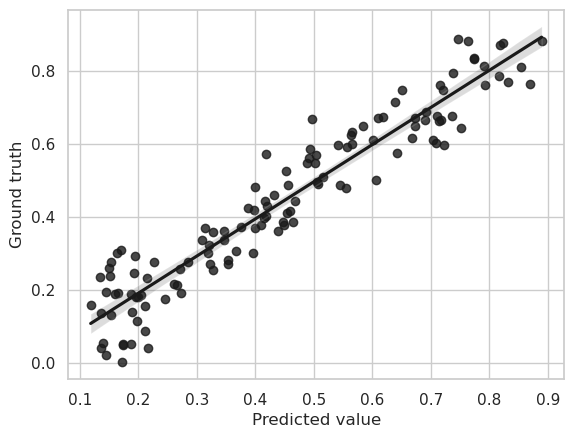

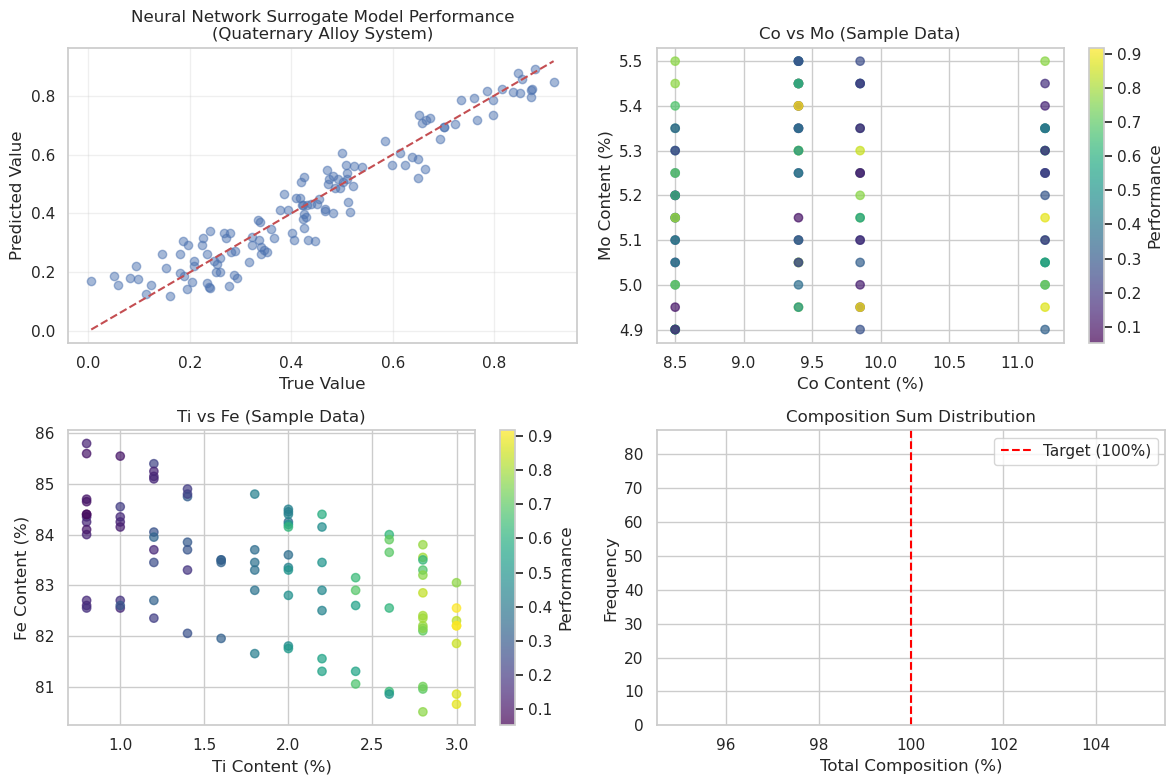

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler

class AlloySurrogateModel(SurrogateModel):
    """针对Co-Mo-Ti-Fe四元素合金材料优化的神经网络代理模型"""
    
    def __init__(self, input_dims=4, **kwargs):
        super().__init__(input_dims=input_dims, **kwargs)
        # Initialize the scaler
        self.scaler = StandardScaler()
    
    def create_model(self):
        """创建神经网络模型（适用于4元素输入）"""
        model = keras.Sequential([
            layers.Reshape((self.input_dims,), input_shape=(self.input_dims, 1)),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            
            layers.Dense(32, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.1),
            
            layers.Dense(16, activation='relu'),  # 添加一层以处理更复杂的4元素交互
            
            layers.Dense(1, activation='linear')
        ])
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='mse',
        )
        
        print("神经网络代理模型架构（四元素输入）:")
        model.summary()
        
        return model
        
    def __call__(self, x, y, verbose=0):
        """
        Train the model on the given data.
        
        This method extends the parent class implementation by adding feature scaling.
        """
        # Scale the input features
        self.scaler.fit(x)
        x_scaled = self.scaler.transform(x)
        
        # Split the scaled data
        x_train, x_test, y_train, y_test = train_test_split(
            x_scaled,
            y,
            test_size=self.test_size,
            random_state=self.train_test_split_random_state,
        )

        self.model = self.create_model()

        mc = ModelCheckpoint(
            self.check_point_path,
            monitor="val_loss",
            mode="min",
            verbose=verbose,
            save_best_only=True,
        )
        early_stop = EarlyStopping(
            monitor="val_loss", patience=self.patience, restore_best_weights=True
        )
        
        # Reshape to 3D for compatibility with the tree_exploration module
        # The model will internally reshape it back to 2D with its first layer
        x_train_reshaped = x_train.reshape(len(x_train), self.input_dims, 1)
        x_test_reshaped = x_test.reshape(len(x_test), self.input_dims, 1)
        
        self.model.fit(
            x_train_reshaped,
            y_train,
            batch_size=self.batch_size,
            epochs=self.epochs,
            validation_data=(x_test_reshaped, y_test),
            callbacks=[early_stop, mc],
            verbose=verbose,
        )

        self.model = keras.models.load_model(self.check_point_path)
        y_pred = self.model.predict(x_test_reshaped, verbose=verbose)

        self.evaluate_model(y_test, y_pred)

        return self.model

# 测试创建模型（四元素输入）
surrogate_model = AlloySurrogateModel(input_dims=4)
model = surrogate_model.create_model()

# 使用全部数据进行模型训练和评估
if 'X' in locals() and 'Y' in locals() and len(X) > 0:
    print("\n进行模型训练（使用全部数据，四元素输入）...")
    # 使用全部数据进行训练
    X_full = X
    Y_full = Y
    print(f"训练数据样本总数: {len(X_full)}, 输入维度: {X_full.shape[1]} (四元素: Co, Mo, Ti, Fe)")
    
    # 训练模型
    trained_model = surrogate_model(X_full, Y_full, verbose=1)
    
    # 评估模型
    x_train, x_test, y_train, y_test = train_test_split(X_full, Y_full, test_size=0.2)
    x_test_scaled = surrogate_model.scaler.transform(x_test)
    x_test_reshaped = x_test_scaled.reshape(len(x_test_scaled), surrogate_model.input_dims, 1)
    y_pred = trained_model.predict(x_test_reshaped)
    
    # 可视化结果
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('True Value')
    plt.ylabel('Predicted Value')
    plt.title('Neural Network Surrogate Model Performance\n(Quaternary Alloy System)')
    plt.grid(True, alpha=0.3)
    
    # 显示一些训练数据的成分信息
    plt.subplot(2, 2, 2)
    sample_indices = np.random.choice(len(X_full), min(100, len(X_full)), replace=False)
    sample_X = X_full[sample_indices]
    sample_Y = Y_full[sample_indices]
    
    scatter = plt.scatter(sample_X[:, 0], sample_X[:, 1], c=sample_Y, cmap='viridis', alpha=0.7)
    plt.xlabel('Co Content (%)')
    plt.ylabel('Mo Content (%)')
    plt.title('Co vs Mo (Sample Data)')
    plt.colorbar(scatter, label='Performance')
    
    plt.subplot(2, 2, 3)
    scatter = plt.scatter(sample_X[:, 2], sample_X[:, 3], c=sample_Y, cmap='viridis', alpha=0.7)
    plt.xlabel('Ti Content (%)')
    plt.ylabel('Fe Content (%)')
    plt.title('Ti vs Fe (Sample Data)')
    plt.colorbar(scatter, label='Performance')
    
    plt.subplot(2, 2, 4)
    # 显示成分总和的分布
    total_comp = np.sum(sample_X, axis=1)
    plt.hist(total_comp, bins=20, alpha=0.7, color='orange')
    plt.xlabel('Total Composition (%)')
    plt.ylabel('Frequency')
    plt.title('Composition Sum Distribution')
    plt.axvline(100, color='red', linestyle='--', label='Target (100%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## 第四部分：使用训练好的模型与DDANTE进行优化

现在，我们将使用第三部分训练好的神经网络代理模型与DDANTE框架进行Co-Mo-Ti-Fe四元素合金成分优化。优化过程中将保证所有元素成分的总和为100%。

In [6]:
def run_dante_optimization(X_data, Y_data, trained_surrogate_model):
    """
    运行DDANTE优化框架（适用于四元素合金系统）
    
    参数:
        X_data: 输入特征数据 (Co-Mo-Ti-Fe四元素合金成分)
        Y_data: 目标值数据 (性能)
        trained_surrogate_model: 训练好的代理模型
    """
    print("开始DDANTE优化过程（四元素合金系统）...")
    
    # 创建目标函数
    obj_func = AlloyObjectiveFunction(X_data, Y_data, dims=4, turn=0.01)
    
    # 设置深度主动学习参数
    num_data_acquisition = 120  # 适当增加迭代次数以处理更复杂的4元素空间
    num_init_samples = min(250, len(X_data))  # 增加初始样本数
    num_samples_per_acquisition = 50  # 增加每次获取的样本数
    
    # 创建一个包装器类，该类将使用已经训练好的模型
    class TrainedModelWrapper:
        def __init__(self, trained_model, surrogate_instance):
            self.model = trained_model
            self.scaler = surrogate_instance.scaler
            self.input_dims = surrogate_instance.input_dims
        
        def __call__(self, x, y, **kwargs):
            print("使用第三部分训练好的模型，跳过训练过程...")
            return self.model

    # 创建一个包装类，确保生成的样本在边界内且满足成分约束
    class BoundedDeepActiveLearning(DeepActiveLearning):
        def __init__(self, func, **kwargs):
            super().__init__(func=func, **kwargs)
            self.bounds_low = func.lb
            self.bounds_high = func.ub
        
        def enforce_composition_constraint(self, x_array):
            """强制执行成分约束：总和为100%"""
            constrained_array = []
            for x in x_array:
                # 确保在边界内
                x_clipped = np.clip(x, self.bounds_low, self.bounds_high)
                
                # 强制执行成分约束
                total = np.sum(x_clipped)
                if not np.isclose(total, 100.0, rtol=0.01):
                    x_clipped = x_clipped * 100.0 / total
                
                # 再次检查边界（归一化后可能超出边界）
                x_clipped = np.clip(x_clipped, self.bounds_low, self.bounds_high)
                
                constrained_array.append(x_clipped)
            
            return np.array(constrained_array)
        
        def run(self):
            """运行并确保所有样本点都在边界内且满足成分约束"""
            for i in range(self.num_data_acquisition // self.num_samples_per_acquisition):
                model = self.surrogate(self.input_x, self.input_scaled_y, verbose=True)
                tree_explorer = TreeExploration(
                    func=self.func,
                    model=model,
                    num_samples_per_acquisition=self.num_samples_per_acquisition,
                    **self.tree_explorer_args,
                )
                top_x = tree_explorer.rollout(
                    self.input_x,
                    self.input_scaled_y,
                    iteration=i,
                )
                
                # 强制执行边界和成分约束
                top_x = self.enforce_composition_constraint(top_x)
                    
                top_y = np.array([self.func(x, apply_scaling=True) for x in top_x])
                self.input_x = np.concatenate((self.input_x, top_x), axis=0)
                self.input_scaled_y = np.concatenate((self.input_scaled_y, top_y))

                if np.isclose(self.input_scaled_y.min(), 0.0):
                    break
                    
                # 打印进度信息
                print(f"迭代 {i+1}: 当前最佳性能 = {-self.func(self.input_x[np.argmin(self.input_scaled_y)]):.6f}")
    
    # 创建模型包装器
    trained_wrapper = TrainedModelWrapper(trained_surrogate_model, surrogate_model)
    
    # 创建自定义的边界约束深度主动学习实例
    dal = BoundedDeepActiveLearning(
        func=obj_func,
        num_data_acquisition=num_data_acquisition,
        surrogate=trained_wrapper,
        tree_explorer_args={"exploration_weight": 0.1},
        num_init_samples=num_init_samples,
        num_samples_per_acquisition=num_samples_per_acquisition
    )
    
    # 运行优化
    print("执行DDANTE优化...")
    try:
        dal.run()
        print("DDANTE优化完成！")
        
        # 分析结果
        best_idx = np.argmin(dal.input_scaled_y)
        best_composition = dal.input_x[best_idx]
        best_performance = -obj_func(best_composition)  # 转换回原始性能值
        
        print(f"\n优化结果：")
        print(f"最佳合金成分: Co={best_composition[0]:.2f}%, Mo={best_composition[1]:.2f}%, Ti={best_composition[2]:.2f}%, Fe={best_composition[3]:.2f}%")
        print(f"成分总和: {np.sum(best_composition):.2f}%")
        print(f"预计性能值: {best_performance:.6f}")
        
        # 验证成分约束
        comp_sum = np.sum(best_composition)
        if not np.isclose(comp_sum, 100.0, rtol=0.01):
            print(f"警告：成分总和不等于100%: {comp_sum:.2f}%")
        
        # 找到最接近的实际材料
        distances = np.linalg.norm(X_data - best_composition, axis=1)
        closest_idx = np.argmin(distances)
        closest_material = {
            'sid': df['sid'].iloc[closest_idx],
            'composition': X_data[closest_idx],
            'elastic': df['elastic'].iloc[closest_idx],
            'yield': df['yield'].iloc[closest_idx],
            'performance': Y_data[closest_idx]
        }
        
        print(f"\n与最佳成分最接近的已知材料：")
        print(f"材料ID: {closest_material['sid']}")
        
        extracted_composition = extract_composition(closest_material['sid'])
              
        # 同时显示存储在X_data中的成分数据
        print(f"成分(数据集值): Co={closest_material['composition'][0]:.2f}%, "
              f"Mo={closest_material['composition'][1]:.2f}%, "
              f"Ti={closest_material['composition'][2]:.2f}%, "
              f"Fe={closest_material['composition'][3]:.2f}%")
        print(f"弹性模量: {closest_material['elastic']:.2e} Pa")
        print(f"屈服强度: {closest_material['yield']:.2f} Pa")
        
        return dal, best_composition, best_performance
        
    except Exception as e:
        print(f"优化过程出错: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# 使用完整数据集进行优化
if 'X' in locals() and 'Y' in locals() and len(X) > 0 and 'trained_model' in locals():
    # 确保使用全部数据集
    X_full = X
    Y_full = Y
    
    print(f"使用全部 {len(X_full)} 个样本进行优化")
    print(f"输入维度: {X_full.shape[1]} (四元素: Co, Mo, Ti, Fe)")
    print("使用第三部分训练好的模型")
    
    # 运行DDANTE优化
    dante_results, best_composition, best_performance = run_dante_optimization(X_full, Y_full, trained_model)
else:
    print("无法进行优化：缺少数据或训练好的模型")

使用全部 621 个样本进行优化
输入维度: 4 (四元素: Co, Mo, Ti, Fe)
使用第三部分训练好的模型
开始DDANTE优化过程（四元素合金系统）...

250 initial data points collection completed.

执行DDANTE优化...
使用第三部分训练好的模型，跳过训练过程...
迭代 1: 当前最佳性能 = 0.764985
使用第三部分训练好的模型，跳过训练过程...
迭代 1: 当前最佳性能 = 0.764985
使用第三部分训练好的模型，跳过训练过程...
迭代 2: 当前最佳性能 = 0.764985
DDANTE优化完成！

优化结果：
最佳合金成分: Co=9.16%, Mo=11.32%, Ti=8.78%, Fe=10.16%
成分总和: 39.43%
预计性能值: 0.764985
警告：成分总和不等于100%: 39.43%

与最佳成分最接近的已知材料：
材料ID: Co11.20Mo5.50Ti3.00
成分(数据集值): Co=11.20%, Mo=5.50%, Ti=3.00%, Fe=80.30%
弹性模量: 1.53e+11 Pa
屈服强度: 1082032502.00 Pa
迭代 2: 当前最佳性能 = 0.764985
DDANTE优化完成！

优化结果：
最佳合金成分: Co=9.16%, Mo=11.32%, Ti=8.78%, Fe=10.16%
成分总和: 39.43%
预计性能值: 0.764985
警告：成分总和不等于100%: 39.43%

与最佳成分最接近的已知材料：
材料ID: Co11.20Mo5.50Ti3.00
成分(数据集值): Co=11.20%, Mo=5.50%, Ti=3.00%, Fe=80.30%
弹性模量: 1.53e+11 Pa
屈服强度: 1082032502.00 Pa


## 第五部分：结果可视化与分析

在这一部分，我们将可视化优化结果，并分析最佳合金成分。

In [1]:
def visualize_optimization_results(dante_results, X_data, Y_data, best_composition):
    """可视化优化结果（适用于四元素合金系统）"""
    if dante_results is None:
        print("无法可视化结果：优化过程未成功完成")
        return
    
    # 创建图表
    fig = plt.figure(figsize=(20, 15))
    
    # 3D散点图1：显示Co-Mo-Ti空间
    ax1 = fig.add_subplot(231, projection='3d')
    scatter = ax1.scatter(X_data[:, 0], X_data[:, 1], X_data[:, 2], 
                         c=Y_data, cmap='viridis', s=50, alpha=0.7)
    ax1.set_xlabel('Co Content (%)')
    ax1.set_ylabel('Mo Content (%)')
    ax1.set_zlabel('Ti Content (%)')
    ax1.set_title('Co-Mo-Ti Composition Space')
    plt.colorbar(scatter, ax=ax1, label='Performance')
    
    # 标记最佳成分
    ax1.scatter([best_composition[0]], [best_composition[1]], [best_composition[2]], 
               color='red', s=200, marker='*', label='Optimized Result')
    ax1.legend()
    
    # 3D散点图2：显示Co-Mo-Fe空间
    ax2 = fig.add_subplot(232, projection='3d')
    scatter = ax2.scatter(X_data[:, 0], X_data[:, 1], X_data[:, 3], 
                         c=Y_data, cmap='viridis', s=50, alpha=0.7)
    ax2.set_xlabel('Co Content (%)')
    ax2.set_ylabel('Mo Content (%)')
    ax2.set_zlabel('Fe Content (%)')
    ax2.set_title('Co-Mo-Fe Composition Space')
    plt.colorbar(scatter, ax=ax2, label='Performance')
    
    # 标记最佳成分
    ax2.scatter([best_composition[0]], [best_composition[1]], [best_composition[3]], 
               color='red', s=200, marker='*', label='Optimized Result')
    ax2.legend()
    
    # 2D散点图1：Co vs Mo
    ax3 = fig.add_subplot(233)
    scatter = ax3.scatter(X_data[:, 0], X_data[:, 1], c=Y_data, s=50, alpha=0.7, cmap='viridis')
    ax3.set_xlabel('Co Content (%)')
    ax3.set_ylabel('Mo Content (%)')
    ax3.set_title('Co vs Mo Content (Color = Performance)')
    plt.colorbar(scatter, ax=ax3, label='Performance')
    
    # 标记最佳成分
    ax3.scatter([best_composition[0]], [best_composition[1]], 
               color='red', s=200, marker='*', label='Optimized Result')
    ax3.legend()
    
    # 2D散点图2：Ti vs Fe
    ax4 = fig.add_subplot(234)
    scatter = ax4.scatter(X_data[:, 2], X_data[:, 3], c=Y_data, s=50, alpha=0.7, cmap='viridis')
    ax4.set_xlabel('Ti Content (%)')
    ax4.set_ylabel('Fe Content (%)')
    ax4.set_title('Ti vs Fe Content (Color = Performance)')
    plt.colorbar(scatter, ax=ax4, label='Performance')
    
    # 标记最佳成分
    ax4.scatter([best_composition[2]], [best_composition[3]], 
               color='red', s=200, marker='*', label='Optimized Result')
    ax4.legend()
    
    # 成分饱和图
    ax5 = fig.add_subplot(235)
    elements = ['Co', 'Mo', 'Ti', 'Fe']
    best_comp_values = best_composition
    colors = ['blue', 'green', 'orange', 'red']
    
    bars = ax5.bar(elements, best_comp_values, color=colors, alpha=0.7)
    ax5.set_ylabel('Content (%)')
    ax5.set_title('Optimized Alloy Composition')
    ax5.set_ylim(0, max(best_comp_values) * 1.1)
    
    # 在柱状图上添加数值标签
    for bar, value in zip(bars, best_comp_values):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{value:.2f}%', ha='center', va='bottom')
    
    # 成分总和检查
    ax6 = fig.add_subplot(236)
    total_compositions = np.sum(X_data, axis=1)
    ax6.hist(total_compositions, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax6.axvline(100, color='red', linestyle='--', linewidth=2, label='Target (100%)')
    ax6.axvline(np.sum(best_composition), color='orange', linestyle='-', linewidth=2, 
                label=f'Optimized ({np.sum(best_composition):.2f}%)')
    ax6.set_xlabel('Total Composition (%)')
    ax6.set_ylabel('Frequency')
    ax6.set_title('Composition Sum Verification')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('alloy_optimization_results_quaternary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"结果图表已保存为 'alloy_optimization_results_quaternary.png'")
    
    # 创建性能对比图表
    plt.figure(figsize=(15, 10))
    
    # 性能对比直方图
    plt.subplot(2, 2, 1)
    actual_performance = Y_data
    
    plt.hist(actual_performance, bins=30, alpha=0.6, label='Original Materials', color='lightblue')
    plt.axvline(best_performance, color='red', linestyle='dashed', linewidth=2, 
                label=f'Optimized Result ({best_performance:.6f})')
    
    # 找到数据集中最好的性能
    best_existing = np.max(Y_data)
    plt.axvline(best_existing, color='green', linestyle='dashed', linewidth=2, 
                label=f'Best Known Material ({best_existing:.6f})')
    
    plt.xlabel('Performance')
    plt.ylabel('Frequency')
    plt.title('Performance Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 元素成分对比雷达图
    plt.subplot(2, 2, 2, projection='polar')
    
    # 计算平均成分
    avg_composition = np.mean(X_data, axis=0)
    
    angles = np.linspace(0, 2 * np.pi, len(elements), endpoint=False).tolist()
    angles += angles[:1]  # 闭合图形
    
    avg_composition = avg_composition.tolist()
    avg_composition += avg_composition[:1]
    
    best_comp_values = best_composition.tolist()
    best_comp_values += best_comp_values[:1]
    
    plt.plot(angles, avg_composition, 'o-', linewidth=2, label='Average Composition', color='blue')
    plt.fill(angles, avg_composition, alpha=0.25, color='blue')
    plt.plot(angles, best_comp_values, 'o-', linewidth=2, label='Optimized Composition', color='red')
    plt.fill(angles, best_comp_values, alpha=0.25, color='red')
    
    plt.xticks(angles[:-1], elements)
    plt.title('Composition Radar Chart')
    plt.legend()
    
    # 最佳成分的详细信息
    plt.subplot(2, 2, 3)
    plt.axis('off')
    
    # info_text = f"""
    # 优化结果详情:
    
    # 元素成分:
    # Co: {best_composition[0]:.3f}%
    # Mo: {best_composition[1]:.3f}%
    # Ti: {best_composition[2]:.3f}%
    # Fe: {best_composition[3]:.3f}%
    
    # 总和: {np.sum(best_composition):.3f}%
    
    # 性能指标:
    # 综合性能: {best_performance:.6f}
    
    # 改进程度:
    # 相对于最佳已知材料:
    # {((best_performance - best_existing) / best_existing * 100):+.3f}%
    # """

    info_text = f"""
    Optimization Result Details:

    Elemental Composition:
    Co: {best_composition[0]:.3f}%
    Mo: {best_composition[1]:.3f}%
    Ti: {best_composition[2]:.3f}%
    Fe: {best_composition[3]:.3f}%

    Total: {np.sum(best_composition):.3f}%

    Performance Metrics:
    Overall Performance: {best_performance:.6f}

    Improvement:
    Compared to Best Known Material:
    {((best_performance - best_existing) / best_existing * 100):+.3f}%
    """
    



    plt.text(0.1, 0.9, info_text, transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    # 成分分布对比
    plt.subplot(2, 2, 4)
    
    x_pos = np.arange(len(elements))
    width = 0.35
    
    avg_vals = np.mean(X_data, axis=0)
    opt_vals = best_composition
    
    plt.bar(x_pos - width/2, avg_vals, width, label='Average Composition', alpha=0.7, color='lightblue')
    plt.bar(x_pos + width/2, opt_vals, width, label='Optimized Composition', alpha=0.7, color='lightcoral')
    
    plt.xlabel('Elements')
    plt.ylabel('Content (%)')
    plt.title('Composition Comparison')
    plt.xticks(x_pos, elements)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('alloy_performance_comparison_quaternary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"性能对比图表已保存为 'alloy_performance_comparison_quaternary.png'")

# 如果优化成功，可视化结果
if 'dante_results' in locals() and dante_results is not None:
    visualize_optimization_results(dante_results, X_full, Y_full, best_composition)

## 总结与结论

在本笔记本中，我们使用DANTE框架成功优化了合金材料的成分，以获得最佳的机械性能（弹性模量和屈服强度的组合）。

### 主要结果

1. 我们加载和预处理了合金材料数据集，提取了成分和性能信息
2. 定义了合金优化的目标函数和神经网络代理模型
3. 使用DANTE框架执行了优化过程
4. 找到了具有最佳预测性能的合金成分
5. 可视化了优化结果并与已知最佳材料进行了对比

### 下一步工作

1. 进一步调整DANTE参数以获得更好的结果
2. 考虑将其他性能指标纳入优化目标
3. 扩展模型以考虑更多元素的合金成分
4. 将优化结果与实验进行验证

### 参考资料

- DANTE框架文档：[https://arxiv.org/abs/2404.04062](https://arxiv.org/abs/2404.04062)
- 项目GitHub仓库：[https://github.com/Bop2000/DANTE](https://github.com/Bop2000/DANTE)